In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns


import gensim
from collections import Counter
import pickle

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, hamming_loss, f1_score

import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization
from keras.preprocessing import text, sequence
from keras import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
dir = "drive/My Drive/BT4221/Data/"
df = pd.read_csv(dir+"cleaned_train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count,char_count,word_density,total_length,capitals,capitals_prop,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_unique_words,prop_unique_words,processed_text,polarity,subjectivity
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,43,223,0.191964,264,17,0.064394,0,1,6,0,41,0.953488,explanation edits made username hardcore metal...,0.136364,0.454545
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,17,95,0.177083,112,8,0.071429,1,0,5,0,17,1.000000,daww match background colour seemingly stuck t...,0.200000,0.200000
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42,192,0.217617,233,4,0.017167,0,0,4,0,39,0.928571,hey man really trying edit war guy constantly ...,0.150000,0.383333
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,113,511,0.220703,622,11,0.017685,0,0,6,0,82,0.725664,ca nt make real suggestion improvement wondere...,0.183333,0.297222
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,55,0.232143,67,2,0.029851,0,1,3,0,13,1.000000,sir hero chance remember page,0.000000,0.000000


In [ ]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  29.1M      0  0:00:49  0:00:49 --:--:-- 30.0M
crawl-300d-2M.vec.zip  drive  sample_data


In [ ]:
!unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [ ]:
# Load the FastText Web Crawl vectors
EMBEDDING_FILE_FASTTEXT="./crawl-300d-2M.vec"
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE_FASTTEXT,encoding='utf-8'))

## Load Data

In [4]:
## split dataset
train, test = train_test_split(df, test_size=0.2, random_state=1234)

X_train = train["processed_text"]
X_test = test["processed_text"]
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values


In [5]:
vocab_size = 10000
max_length = 200

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list(X_train) + list(X_test))

X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(X_train_sequence, maxlen=max_length)
x_test = sequence.pad_sequences(X_test_sequence, maxlen=max_length)
print(len(tokenizer.word_index))

189230


In [ ]:
word_index = tokenizer.word_index
embedding_dim = 300

# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18340001,  0.1092    , -0.0946    , ...,  0.0157    ,
         0.20290001,  0.1182    ],
       [ 0.44310001,  0.28369999, -0.54750001, ..., -0.0851    ,
        -0.54110003,  0.29660001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.78170002, -0.0237    ,  0.2807    , ..., -0.0452    ,
         0.098     , -0.2022    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
# Initate model
model = Sequential()
# Add Embedding layer
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))

#add bi-directional lstm layer
model.add(Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))

# Add output layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

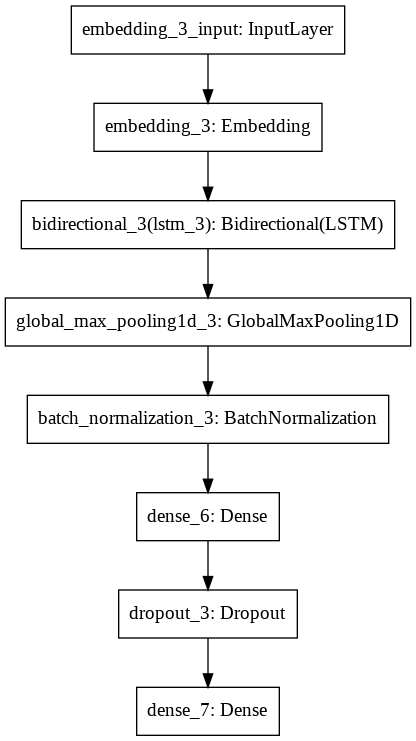

In [ ]:
tf.keras.utils.plot_model(model)


In [ ]:
saved_model = "/content/drive/My Drive/BT4221/Models/LSTM_fasttext.best.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early]

In [ ]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 3, batch_size=128, validation_split=0.2, callbacks=callbacks_list)

Training progress:
Epoch 1/3
798/798 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.6910
Epoch 00001: val_accuracy improved from -inf to 0.96791, saving model to /content/drive/My Drive/BT4221/Models/LSTM_fasttext.best.hdf5
798/798 [==============================] - 1239s 2s/step - loss: 0.0740 - accuracy: 0.6910 - val_loss: 0.0528 - val_accuracy: 0.9679
Epoch 2/3
798/798 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.8757
Epoch 00002: val_accuracy improved from 0.96791 to 0.98538, saving model to /content/drive/My Drive/BT4221/Models/LSTM_fasttext.best.hdf5
798/798 [==============================] - 1246s 2s/step - loss: 0.0489 - accuracy: 0.8757 - val_loss: 0.0522 - val_accuracy: 0.9854
Epoch 3/3
798/798 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9096
Epoch 00003: val_accuracy improved from 0.98538 to 0.98985, saving model to /content/drive/My Drive/BT4221/Models/LSTM_fasttext.best.hdf5
798/798 [==========

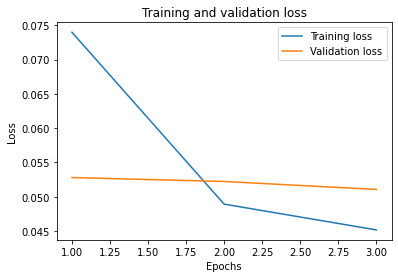

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

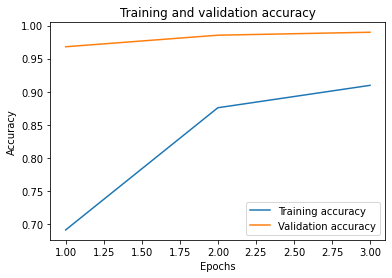

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [6]:
#load the best model
model = keras.models.load_model(filepath='/content/drive/My Drive/BT4221/Models/LSTM_fasttext.best.hdf5')

## Test Accuracy

In [7]:
score = model.evaluate(x=x_test, y= y_test)

print("Loss:", score[0])
print("Test Accuracy:", score[1])

997/997 [==============================] - 102s 102ms/step - loss: 0.0493 - accuracy: 0.9899
Loss: 0.04927678406238556
Test Accuracy: 0.9899062514305115


## Threshold Moving

In [8]:
y_pred = model.predict(x_test)

In [9]:
thresholds = np.arange(0, 1, 0.01)

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
predictions = y_pred
# evaluate each threshold
scores_hl = [hamming_loss(y_test, to_labels(predictions, t)) for t in thresholds]
scores_f1 = [f1_score(y_test, to_labels(predictions, t), average = "macro") for t in thresholds]

# get best threshold
ix_hl = np.argmin(scores_hl)
print('Threshold={}, Min Hamming Loss={}, F1-score = {}'.format(thresholds[ix_hl], scores_hl[ix_hl], scores_f1[ix_hl]))

ix_f1 = np.argmax(scores_f1)
print('Threshold={}, Max F1-score={}, Hamming Loss = {}'.format(thresholds[ix_f1], scores_f1[ix_f1], scores_hl[ix_f1]))

Threshold=0.5700000000000001, Min Hamming Loss=0.017852104949688096, F1-score = 0.5117205020700166
Threshold=0.26, Max F1-score=0.5981802541594651, Hamming Loss = 0.022642968349999477


In [ ]:
# convert float to binary integer
predictions = y_pred
thresholds = [0.260]
for val in thresholds:
  y_pred_copy=predictions.copy()

  y_pred_copy[y_pred_copy>=val]=1
  y_pred_copy[y_pred_copy<val]=0

cm = multilabel_confusion_matrix(y_test, y_pred_copy)

In [ ]:
def precision_recall(cmat): 
    tp = cmat[0][0] 
    fp = cmat[0][1] 
    fn = cmat[1][0] 
    tn = cmat[1][1] 
    return tp/(tp+fp), tp/(tp+fn)

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    #compute tp, tp_and_fn and tp_and_fp w.r.t all classes
    precision, recall = precision_recall(confusion_matrix)

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

    print(class_label)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print()

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

toxic
Precision: 0.9801078073378543
Recall: 0.975527864312911

severe_toxic
Precision: 0.9942375886524822
Recall: 0.9946784922394678

obscene
Precision: 0.9917752794083508
Recall: 0.9877786952931462

threat
Precision: 0.9996855840276686
Recall: 0.9972399084151429

insult
Precision: 0.98673705047839
Recall: 0.9837187119692136

identity_hate
Precision: 0.9991144004807541
Recall: 0.9927404148334381



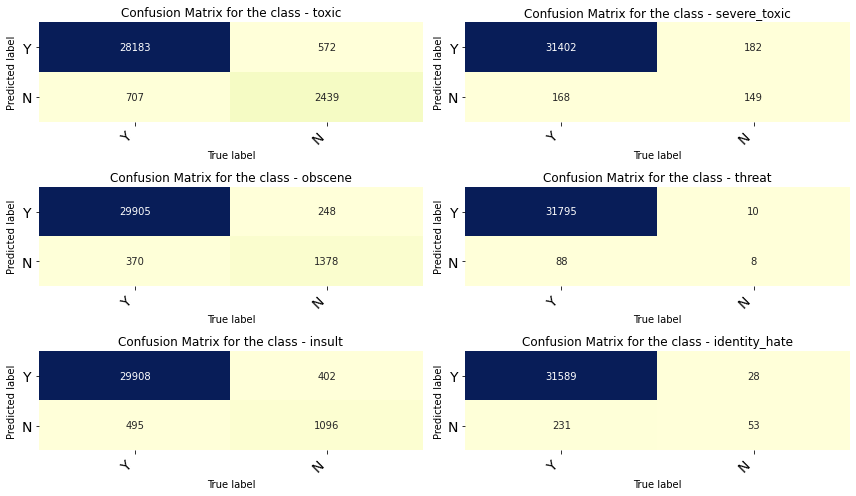

In [ ]:
# use threshold of 0.5
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):

  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()  

toxic
Precision: 0.9921057207442184
Recall: 0.9638814744737643

severe_toxic
Precision: 0.9994300911854104
Recall: 0.9907099366015943

obscene
Precision: 0.9954233409610984
Recall: 0.981042654028436

threat
Precision: 1.0
Recall: 0.9970219435736677

insult
Precision: 0.9903002309468822
Recall: 0.9794746288138358

identity_hate
Precision: 0.9998734857829649
Recall: 0.9917803921568628



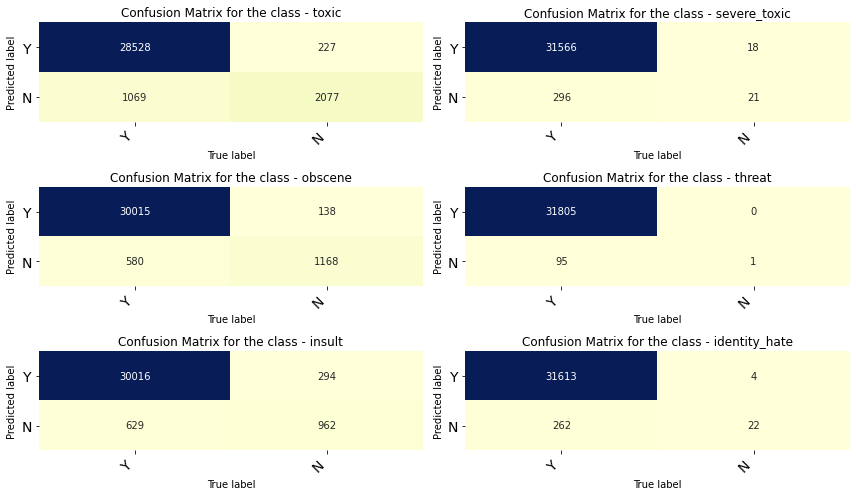

In [ ]:
# maximize hamming loss
# use threshold of 0.57
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):

  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()  

toxic
Precision: 0.9583029038428099
Recall: 0.9840725662452682

severe_toxic
Precision: 0.9868287740628167
Recall: 0.996801842138928

obscene
Precision: 0.983815872384174
Recall: 0.9925056040683864

threat
Precision: 0.9988366609023739
Recall: 0.9979580938020294

insult
Precision: 0.972484328604421
Recall: 0.9908232209486033

identity_hate
Precision: 0.9974380871050385
Recall: 0.9946068691456146



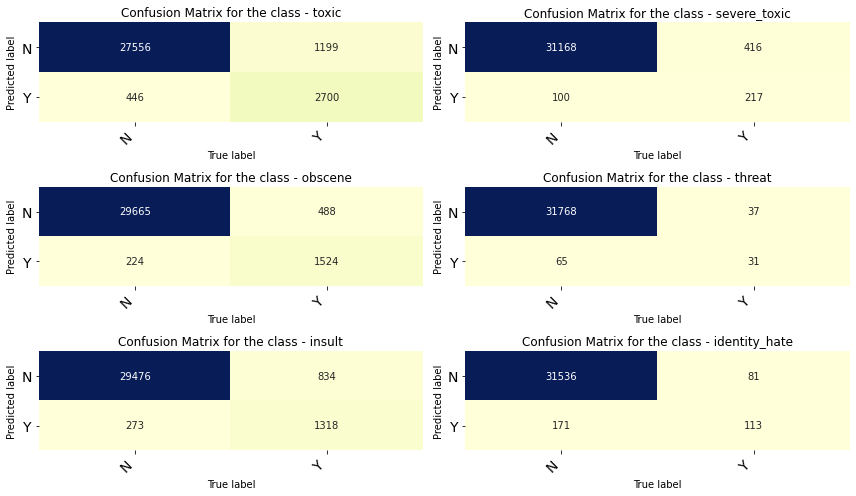

In [ ]:
# maximize F-score
# use threshold of 0.57
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):

  print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()  